In [129]:
#imports only
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.discriminant_analysis as skl_da
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score

In [130]:
file_path = 'siren_data_train.csv'
data = pd.read_csv(file_path)
data.head()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29
2,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32
3,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36
4,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55


In [131]:
#add distance to horn
# Calculate Euclidean distance between person and nearest horn
data['dist'] = np.sqrt((data['xcoor'] - data['near_x'])**2 + (data['ycoor'] - data['near_y'])**2)


In [132]:
data = data.drop(columns=["near_fid"], axis=1) #drop near_fid as it doesnt make sense to have (is only an ID)
semi_original_data = data.copy() #make copy to be able to use later

# Data exploration

### Distance

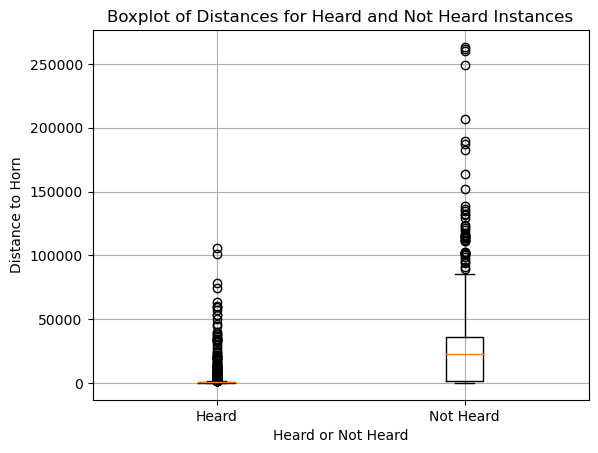

In [133]:
df = data

dist_heard = df[df['heard'] == 1]['dist']
dist_not_heard = df[df['heard'] == 0]['dist']

all_distances = [distances_heard, distances_not_heard]

plt.boxplot(all_distances, labels=['Heard', 'Not Heard'])
plt.title('Boxplot of Distances for Heard and Not Heard Instances')
plt.xlabel('Heard or Not Heard')
plt.ylabel('Distance to Horn')
plt.grid(True)
plt.show()


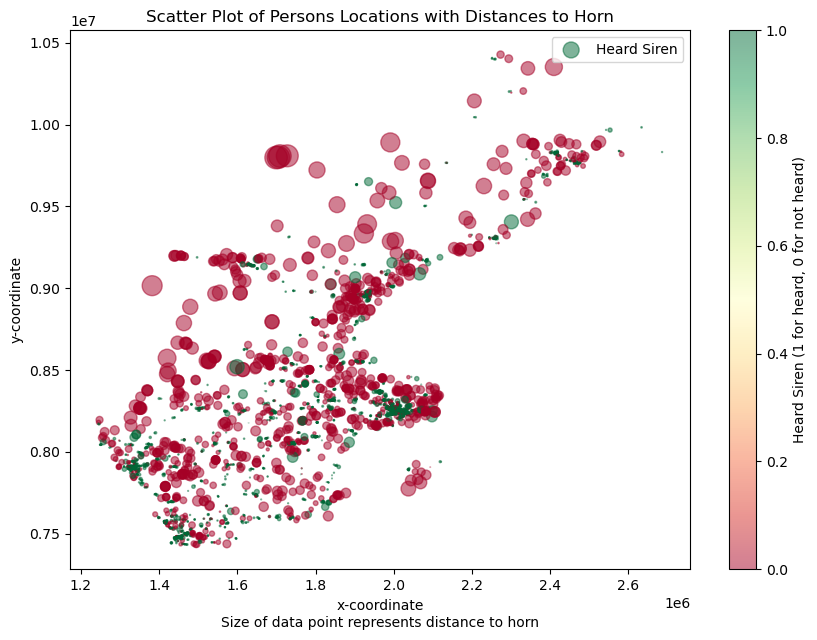

In [134]:
scaling_factor = 0.001  #scaling the distance as some distances are huge

plt.figure(figsize=(10, 7))
scatter = plt.scatter(data["xcoor"], data["ycoor"], alpha=0.5, 
                      c=data["heard"], cmap='RdYlGn', label="Heard Siren",
                      s=data["dist"] * scaling_factor, marker='o')
plt.colorbar(scatter, label='Heard Siren (1 for heard, 0 for not heard)')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Scatter Plot of Persons Locations with Distances to Horn')
plt.legend()

plt.text(0.5, -0.1, "Size of data point represents distance to horn", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()


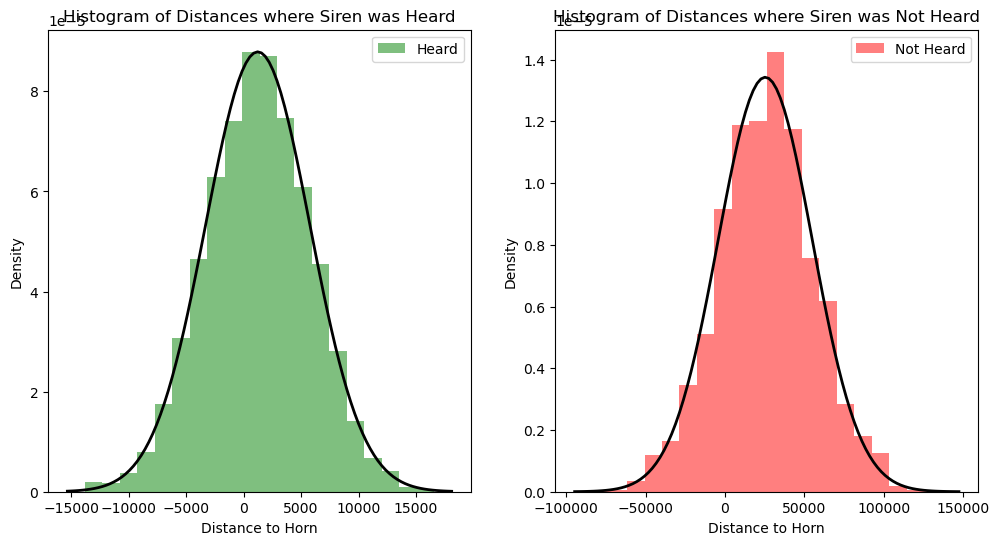

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate synthetic data following a Gaussian distribution for heard and not heard distances
mu_heard = np.mean(dist_heard)  # Mean of the distribution for heard distances
sigma_heard = np.std(dist_heard)  # Standard deviation of the distribution for heard distances
num_samples_heard = len(dist_heard)  # Number of samples for heard distances

mu_not_heard = np.mean(dist_not_heard)  # Mean of the distribution for not heard distances
sigma_not_heard = np.std(dist_not_heard)  # Standard deviation of the distribution for not heard distances
num_samples_not_heard = len(dist_not_heard)  # Number of samples for not heard distances

# Generate synthetic data for heard distances
distances_heard = np.random.normal(mu_heard, sigma_heard, num_samples_heard)

# Generate synthetic data for not heard distances
distances_not_heard = np.random.normal(mu_not_heard, sigma_not_heard, num_samples_not_heard)

# Plot the histograms for heard and not heard distances
plt.figure(figsize=(12, 6))

# Plot for heard distances
plt.subplot(1, 2, 1)
plt.hist(distances_heard, bins=20, density=True, alpha=0.5, color='green', label='Heard')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_heard, sigma_heard)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Distance to Horn')
plt.ylabel('Density')
plt.title('Histogram of Distances where Siren was Heard')
plt.legend()

# Plot for not heard distances
plt.subplot(1, 2, 2)
plt.hist(distances_not_heard, bins=20, density=True, alpha=0.5, color='red', label='Not Heard')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_not_heard, sigma_not_heard)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Distance to Horn')
plt.ylabel('Density')
plt.title('Histogram of Distances where Siren was Not Heard')
plt.legend()

plt.show()


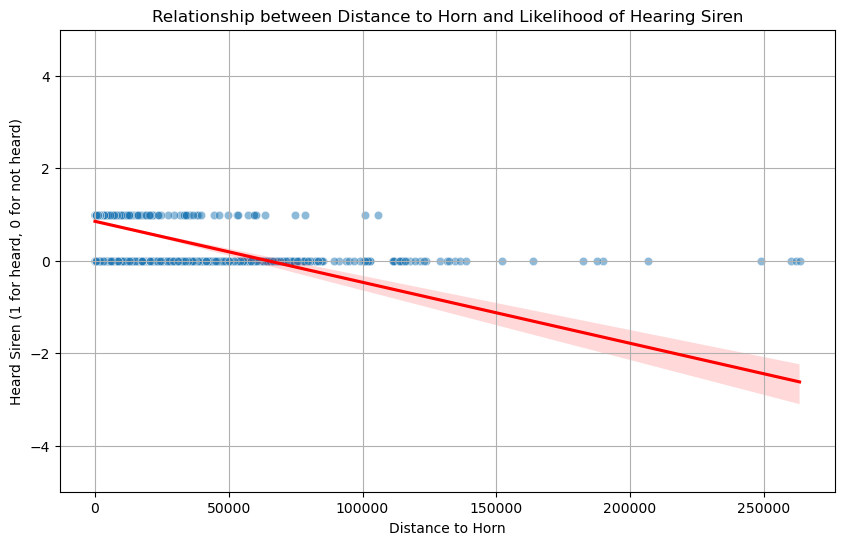

In [136]:
# Assuming 'dist' represents distance and 'heard' represents whether the siren was heard (1 for heard, 0 for not heard)

# Plotting the relationship between distance and likelihood of hearing the siren
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dist', y='heard', data=data, alpha=0.5)

# Fitting a trend line (e.g., linear regression) to visualize the relationship
sns.regplot(x='dist', y='heard', data=data, scatter=False, color='red')

plt.xlabel('Distance to Horn')
plt.ylabel('Heard Siren (1 for heard, 0 for not heard)')
plt.title('Relationship between Distance to Horn and Likelihood of Hearing Siren')

# Set y-axis limits from -3 to 3
plt.ylim(-5, 5)

plt.grid(True)
plt.show()


In [137]:
#### Is there a statistical difference between those that heard the signal and those that didn't given the distance?

# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['dist']
not_heard_distances = data[data['heard'] == 0]['dist']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean distances between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean distances between the heard and not heard groups.")


T-statistic: -51.7056653375075
P-value: 0.0
Reject null hypothesis: There is a significant difference in mean distances between the heard and not heard groups.


## Age

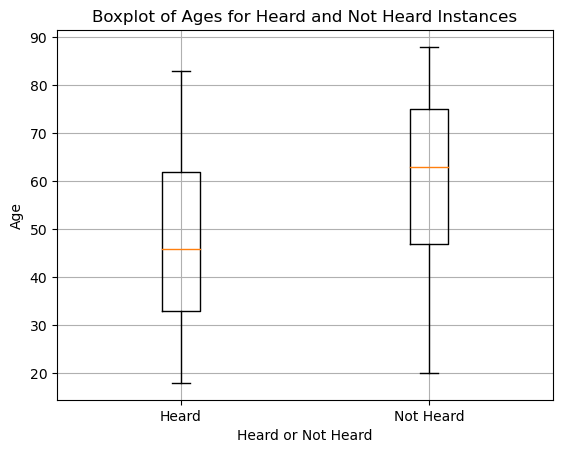

In [138]:
df = data

age_heard = df[df['heard'] == 1]['age']
age_not_heard = df[df['heard'] == 0]['age']

all_ages = [age_heard, age_not_heard]

plt.boxplot(all_ages, labels=['Heard', 'Not Heard'])
plt.title('Boxplot of Ages for Heard and Not Heard Instances')
plt.xlabel('Heard or Not Heard')
plt.ylabel('Age')
plt.grid(True)
plt.show()


In [139]:
# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['age']
not_heard_distances = data[data['heard'] == 0]['age']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean ages between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean ages between the heard and not heard groups.")


T-statistic: -22.79964593973161
P-value: 3.3998771811922806e-110
Reject null hypothesis: There is a significant difference in mean ages between the heard and not heard groups.


### Angles

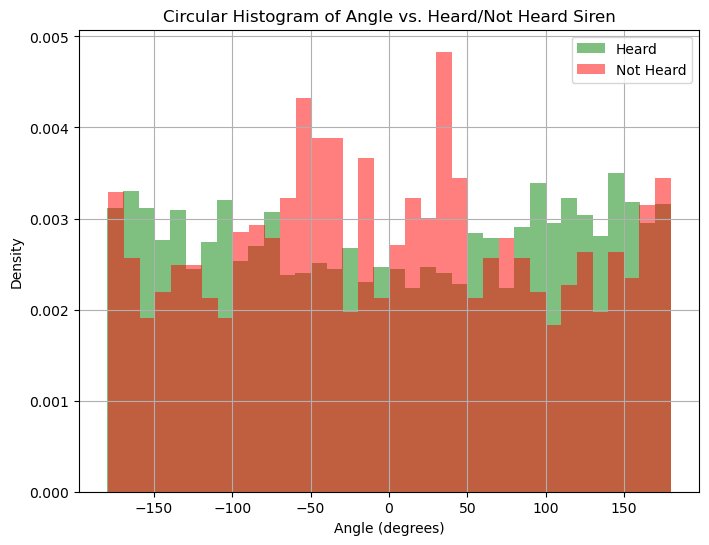

In [140]:
# Extracting data for instances where the siren was heard and not heard
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

# Creating a circular histogram for the angles
plt.figure(figsize=(8, 6))

# Plotting histogram for instances where siren was heard
plt.hist(angles_heard, bins=36, density=True, alpha=0.5, color='green', label='Heard')

# Plotting histogram for instances where siren was not heard
plt.hist(angles_not_heard, bins=36, density=True, alpha=0.5, color='red', label='Not Heard')

plt.title('Circular Histogram of Angle vs. Heard/Not Heard Siren')
plt.xlabel('Angle (degrees)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# Setting polar coordinates
#plt.gca().set_theta_zero_location('N')
#plt.gca().set_theta_direction(-1)

plt.show()


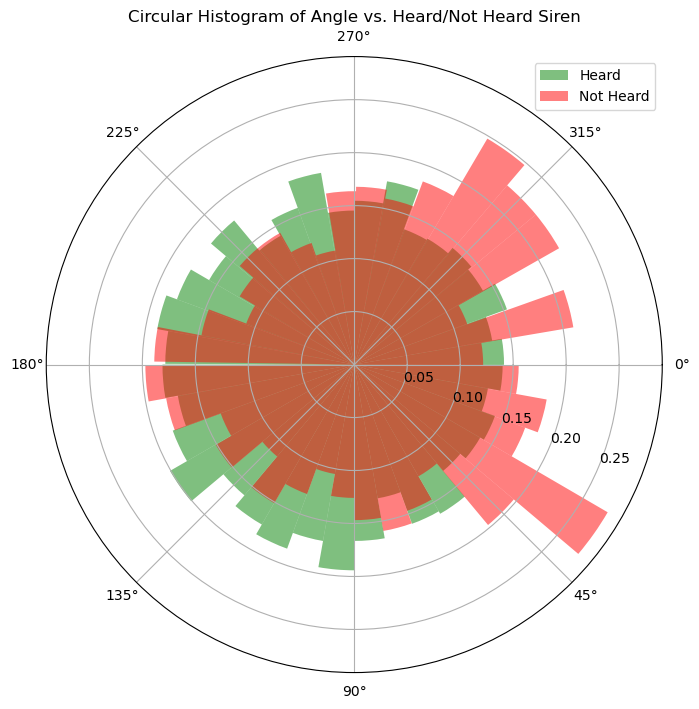

In [141]:
# Assuming 'near_angle' represents the angle data and 'heard' represents whether the siren was heard (1 for heard, 0 for not heard)

# Separate angles for instances where the siren was heard and not heard
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

# Create a polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot angles where the siren was heard
ax.hist(np.radians(angles_heard), bins=36, density=True, alpha=0.5, color='green', label='Heard')

# Plot angles where the siren was not heard
ax.hist(np.radians(angles_not_heard), bins=36, density=True, alpha=0.5, color='red', label='Not Heard')

# Set the direction of the polar plot as clockwise
ax.set_theta_direction(-1)

# Add a legend
plt.legend()
plt.title('Circular Histogram of Angle vs. Heard/Not Heard Siren')

plt.show()


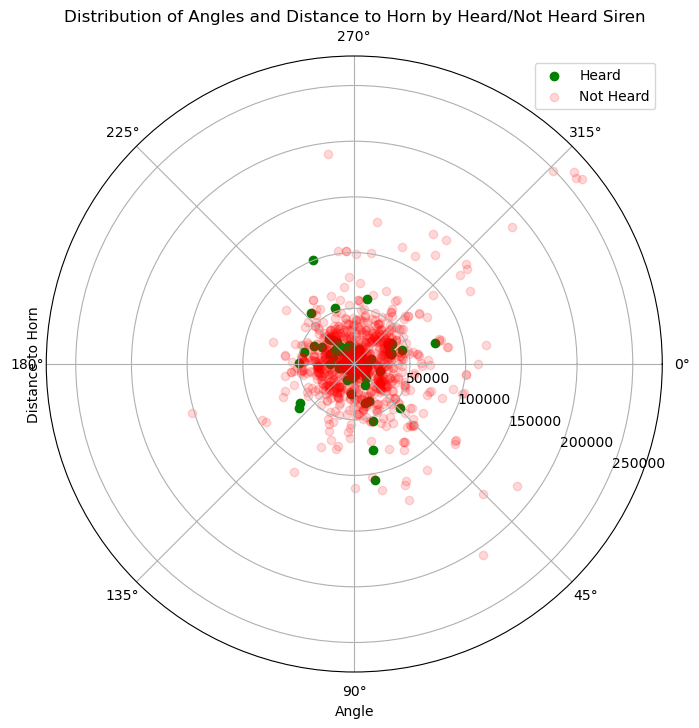

In [142]:
# Assuming 'near_angle' represents the angle data, 'heard' represents whether the siren was heard (1 for heard, 0 for not heard),
# and 'dist' represents the distance to the horn

# Separate angles and distances for instances where the siren was heard and not heard
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

distances_heard = data[data['heard'] == 1]['dist']
distances_not_heard = data[data['heard'] == 0]['dist']

# Create a polar plot
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Plot angles where the siren was heard
ax.scatter(np.radians(angles_heard), distances_heard, alpha=1, color='green', label='Heard')

# Plot angles where the siren was not heard
ax.scatter(np.radians(angles_not_heard), distances_not_heard, alpha=0.15, color='red', label='Not Heard')

# Set the direction of the polar plot as clockwise
ax.set_theta_direction(-1)

# Add labels and title
plt.xlabel('Angle')
plt.ylabel('Distance to Horn')
plt.title('Distribution of Angles and Distance to Horn by Heard/Not Heard Siren')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [143]:
#import numpy as np
#from scipy.stats import ttest_ind

# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['near_angle']
not_heard_distances = data[data['heard'] == 0]['near_angle']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean angles between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean angles between the heard and not heard groups.")


T-statistic: 0.512822563157527
P-value: 0.6080952897476064
Fail to reject null hypothesis: There is no significant difference in mean angles between the heard and not heard groups.


# Creating age grouping

In [144]:
#new bins based on hearing with age research
new_age_bins = [0, 40, 50, 60, 70, float('inf')]
new_age_labels = ['0-39', '40-49', '50-59', '60-69', '70+']
data['age_group'] = pd.cut(data['age'], bins=new_age_bins, labels=new_age_labels, right=False)


In [145]:
dummies = pd.get_dummies(data, columns=["age_group"])
keep_these_original_columns_for_plots = data[["age_group"]]
data = pd.concat([keep_these_original_columns_for_plots, dummies], axis=1)

In [146]:
data.head(10)

,age_group,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,age_group_0-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
0,50-59,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59,901.283517,0,0,1,0,0
1,0-39,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29,972.006260,1,0,0,0,0
2,0-39,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32,872.340924,1,0,0,0,0
3,0-39,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36,257.804449,1,0,0,0,0
4,50-59,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55,529.686791,0,0,1,0,0
5,60-69,1.934971e+06,8.959613e+06,-159.477621,0,1,1938739.0,8961023,0,0,0,1,62,4023.130333,0,0,0,1,0
6,70+,1.327964e+06,7.940968e+06,18.712045,1,1,1327733.0,7940890,0,0,0,0,74,244.293455,0,0,0,0,1
7,0-39,2.005312e+06,8.234592e+06,146.602179,1,0,2007113.0,8233405,0,0,0,0,24,2157.250580,1,0,0,0,0
8,60-69,2.010260e+06,8.244737e+06,91.888991,1,0,2010284.0,8244010,0,0,0,0,66,727.512654,0,0,0,1,0
9,50-59,1.339570e+06,7.892866e+06,160.654726,1,1,1340898.0,7892400,0,0,0,0,53,1407.236379,0,0,1,0,0


# Generate train & test set

In [147]:
#random sampling
def split_train_test(data, test_ratio, random_state): 
    shuffled_indices = np.random.permutation(len(data)) if random_state is None else np.random.RandomState(random_state).permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train, test = split_train_test(data, 0.2, random_state=42)

#drop categorical values 
train = train.drop(columns=["age_group"], axis=1)
test = test.drop(columns=["age_group"], axis=1)

X_train = train.drop(columns=['heard'])
y_train = train['heard']

# Extract features and target for testing set
X_test = test.drop(columns=['heard'])
y_test = test['heard']

In [148]:
X_train

,near_x,near_y,near_angle,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,age_group_0-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
2707,1.539340e+06,7.445810e+06,-94.448289,0,1539356.0,7446015,0,0,0,0,36,205.569128,1,0,0,0,0
4450,1.920911e+06,8.955261e+06,-26.953477,0,1919838.0,8955807,0,0,0,0,45,1204.244641,0,1,0,0,0
5582,2.263289e+06,9.309547e+06,94.793487,0,2263376.0,9308506,0,0,0,0,67,1045.121252,0,0,0,1,0
219,1.801783e+06,8.093233e+06,-126.466310,1,1802002.0,8093529,0,0,0,0,31,367.734663,1,0,0,0,0
4299,1.896830e+06,8.263999e+06,157.136154,0,1898035.0,8263491,0,0,0,0,33,1307.966751,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1.727620e+06,8.054662e+06,-148.946005,0,1727716.0,8054720,1,0,0,0,19,112.516605,1,0,0,0,0
5191,2.009944e+06,8.251584e+06,164.094575,0,2010188.0,8251514,0,0,0,0,77,254.194233,0,0,0,0,1
5226,1.966241e+06,8.366161e+06,63.700957,0,1965821.0,8365312,0,1,0,0,54,946.849130,0,0,1,0,0
5390,2.416546e+06,9.823889e+06,-52.356561,0,2415633.0,9825073,0,0,0,0,45,1495.611103,0,1,0,0,0


In [149]:
y_test

1700    0
2495    1
561     1
5612    0
5278    1
       ..
2754    1
803     1
857     1
2963    1
4919    1
Name: heard, Length: 1142, dtype: int64

# Models

In [150]:
columns_to_remove = []
X_train_LDA = X_train.drop(columns=columns_to_remove , axis=1)
X_test_LDA = X_test.drop(columns=columns_to_remove , axis=1)

In [154]:
# LDA with SMOTE, standardscaler and gridsearch, this cell is only used to find best params and solver
    
smote = SMOTE()
    
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_LDA, y_train)
    
pipeline = make_pipeline(StandardScaler(), skl_da.LinearDiscriminantAnalysis())
    
# Define hyperparams
param_grid = {
    'lineardiscriminantanalysis__solver': ['svd', 'lsqr'],  # solver options for LDA
}
    
# grid search with cross-validation
grid_search_lda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search_lda.fit(X_train_resampled, y_train_resampled)
    
# best hyperparams
print("Best hyperparameters:", grid_search_lda.best_params_)
print("Best CV accuracy:", grid_search_lda.best_score_)
    
# use best model going forward
best_lda_model = grid_search_lda.best_estimator_
    
# predict with best model
prediction_lda = best_lda_model.predict(X_test_LDA)
    
#Results
print("Confusion matrix: \n")
print(pd.crosstab(prediction_lda, y_test), "\n")
print(f"Accuracy: {np.mean(prediction_lda == y_test):.4f}")

print(classification_report(y_test, prediction_lda))



Best hyperparameters: {'lineardiscriminantanalysis__solver': 'svd'}
Best CV accuracy: 0.8836171960850766
Confusion matrix: 

heard    0    1
row_0          
0      186   26
1      104  826 

Accuracy: 0.8862
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       290
           1       0.89      0.97      0.93       852

    accuracy                           0.89      1142
   macro avg       0.88      0.81      0.83      1142
weighted avg       0.89      0.89      0.88      1142



In [155]:
# Random forest
model_tree = RandomForestClassifier(n_estimators=440, random_state=42) #defining which modell to be used
model_tree.fit(X_train, y_train)
model_tree_prediction = model_tree.predict(X_test)

print(pd.crosstab(model_tree_prediction, y_test))
print(f"acc: {np.mean(model_tree_prediction == y_test)}")

f1 = f1_score(y_test, model_tree_prediction)
balanced_acc = balanced_accuracy_score(y_test, model_tree_prediction)

# Compute precision and recall
precision = precision_score(y_test, model_tree_prediction)
recall = recall_score(y_test, model_tree_prediction)

print("F1-score:", f1)
print("Balanced Accuracy:", balanced_acc)
print("Precision:", precision)
print("Recall:", recall)

print(classification_report(y_test, model_tree_prediction))



heard    0    1
row_0          
0      233   25
1       57  827
acc: 0.9281961471103327
F1-score: 0.9527649769585252
Balanced Accuracy: 0.8870527764286871
Precision: 0.9355203619909502
Recall: 0.9706572769953051
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       290
           1       0.94      0.97      0.95       852

    accuracy                           0.93      1142
   macro avg       0.92      0.89      0.90      1142
weighted avg       0.93      0.93      0.93      1142



In [165]:
# Boosting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV

# rescaling with standardscaler
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.transform(X_test)

# Bagging classifier
bag = BaggingClassifier(random_state=42, n_estimators=20)
bag.fit(X_train_rescaled, y_train)
prediction = bag.predict(X_test_rescaled)

accuracy = bag.score(X_test_rescaled, y_test)

print("--- Bagging ---")
print(classification_report(y_test, prediction))

--- Bagging ---
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       290
           1       0.93      0.96      0.95       852

    accuracy                           0.92      1142
   macro avg       0.90      0.88      0.89      1142
weighted avg       0.92      0.92      0.92      1142



In [169]:
# Boosting with AdaBoost

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# rescaling with standardscaler
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.transform(X_test)

#ada_boost = AdaBoostClassifier(random_state=42, n_estimators=100)
#ada_boost.fit(X_train_rescaled, Y_train)
#Y_predict = ada_boost.predict(X_test_rescaled)

#find best params with GridSearch


# Define the pipeline with preprocessing steps (e.g., scaling) and the AdaBoostClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: preprocessing step
    ('adaboost', AdaBoostClassifier(random_state=42))  # AdaBoostClassifier
])

# Define the hyperparameter grid
param_grid = {
    'adaboost__learning_rate': [1, 2, 5, 10, 25]  # Learning rate hyperparameter for AdaBoostClassifier
}

# Perform Grid Search cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_rescaled, y_train)

# Print the best estimator and its hyperparameters
print("Best Estimator: ", grid_search.best_estimator_)

best_estimator = grid_search.best_estimator_

Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ('adaboost',
                 AdaBoostClassifier(learning_rate=1, random_state=42))])


In [174]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the pipeline with preprocessing steps (e.g., scaling) and the AdaBoostClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: preprocessing step
    ('adaboost', AdaBoostClassifier(random_state=42))  # AdaBoostClassifier
])

# Define the hyperparameter grid including both n_estimators and learning_rate
param_grid = {
    'adaboost__n_estimators': [50, 100, 200],  # Number of estimators for AdaBoostClassifier
    'adaboost__learning_rate': [0.01, 0.1, 1.0, 2, 5, 10, 2]  # Learning rate for AdaBoostClassifier
}

# Perform Grid Search cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_rescaled, y_train)

# Print the best estimator and its hyperparameters
print("Best Estimator: ", grid_search.best_estimator_)


Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ('adaboost',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=200,
                                    random_state=42))])


In [178]:
# Best Adaboost classifier
best_boost = AdaBoostClassifier(random_state=42, n_estimators=200, learning_rate=0.1)
best_boost.fit(X_train_rescaled, y_train)
prediction = best_boost.predict(X_test_rescaled)

accuracy = best_boost.score(X_test_rescaled, y_test)

pred_accuracy_score = accuracy_score(y_test, prediction)
report = classification_report(y_test, prediction)

print("--- Best AdaBoost ---")
print(classification_report(y_test, prediction))

--- Best AdaBoost ---
              precision    recall  f1-score   support

           0       0.90      0.78      0.83       290
           1       0.93      0.97      0.95       852

    accuracy                           0.92      1142
   macro avg       0.91      0.87      0.89      1142
weighted avg       0.92      0.92      0.92      1142



##  Each model as a method to call

In [ ]:
def perform_LDA():
    # LDA with SMOTE, standardscaler and gridsearch
    smote = SMOTE()
    
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_LDA, y_train)
    
    pipeline = make_pipeline(StandardScaler(), skl_da.LinearDiscriminantAnalysis())
    
    # Define hyperparams
    param_grid = {
        'lineardiscriminantanalysis__solver': ['svd', 'lsqr'],  # solver options for LDA
    }
    
    # grid search with cross-validation
    grid_search_lda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
    grid_search_lda.fit(X_train_resampled, y_train_resampled)
    
    # use best model going forward
    best_lda_model = grid_search_lda.best_estimator_
    
    # predict with best model
    prediction_lda = best_lda_model.predict(X_test_LDA)
    
    #Results
    #result = grid_search_lda.best_score_

    result_dict = {}
    result_dict['accuracy'] = np.mean(prediction_lda == y_test)
    result_dict['f1'] = f1_score(y_test, prediction_lda)
    result_dict['balanced_accuracy'] = balanced_accuracy_score(y_test, prediction_lda)
    result_dict['precision'] = precision_score(y_test, prediction_lda)
    result_dict['recall'] = recall_score(y_test, prediction_lda)
    
    return result_dict

In [152]:
def perform_random_forest():
    model_tree = RandomForestClassifier(n_estimators=440, random_state=42) #defining which modell to be used
    model_tree.fit(X_train, y_train)
    model_tree_prediction = model_tree.predict(X_test)
    
    #Results
    result_dict = {}
    result_dict['accuracy'] = np.mean(model_tree_prediction == y_test)
    result_dict['f1'] = f1_score(y_test, model_tree_prediction)
    result_dict['balanced_accuracy'] = balanced_accuracy_score(y_test, model_tree_prediction)
    result_dict['precision'] = precision_score(y_test, model_tree_prediction)
    result_dict['recall'] = recall_score(y_test, model_tree_prediction)
    
    return result_dict

In [128]:
#Script to run all models to get balanced accuracies
num_runs = 10
lda_accuracy_array = []
rf_accuracy_array = []

for i in range(10):
    result_dict_lda = perform_LDA()
    lda_accuracy_array.append(result_dict_lda['accuracy'])
    
    #lda_accuracy_array.append(perform_LDA())
    result_dict_rf = perform_random_forest()
    rf_accuracy_array.append(result_dict_rf['accuracy'])

print("---- LDA ----") #Blended Accuracy: 0.8852
print(f"Blended Accuracy: {np.mean(lda_accuracy_array):.4f}")

print("---- Random Forest ----") #Blended Accuracy: 0.9282
print(f"Blended Accuracy: {np.mean(rf_accuracy_array):.4f}")


---- LDA ----
Blended Accuracy: 0.8884
---- Random Forest ----
Blended Accuracy: 0.9282
